### Functional characterization of novel macrophage phenotypes

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings
import anndata
warnings.filterwarnings('ignore')


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './final-figures/merged/myeloid/functional_analysis/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

#### Took this function from: https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/gprofiler_plotting.py

In [2]:
# Plotting functions - 'GProfiler-official version'
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=9, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="OrRd", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 12, 'font.weight': 'normal'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='OrRd', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=12, fontweight='normal')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.10, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.2, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=12, fontweight='normal')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()

In [3]:
from gprofiler import GProfiler

#### Load data 

In [4]:
path_to_gonads = '/nfs/team292/vl6/immune_fetal_gonads/'

In [5]:
adata = sc.read(path_to_gonads + 'macrophages.h5ad')

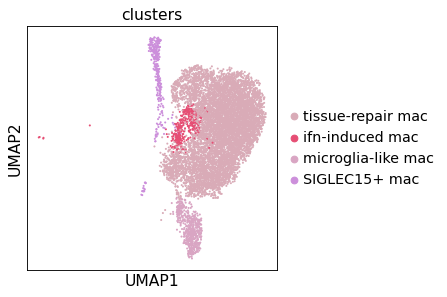

In [6]:
sc.pl.umap(adata, color = 'clusters')

In [7]:
adata.obs.to_csv(path_to_gonads + 'macrophage_annotations.csv')

#### Differential expression analysis

In [8]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [9]:
import anndata
adata = anndata.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)

In [10]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 28497 8875 
metadata(0):
assays(1): X
rownames(28497): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(194): gene_ids.0.0 feature_types.0.0 ...
  feature_types.52.1 n_cells.52.1
colnames(8875): FCA_GND8047884_CTTAGGATCAGTGCAT
  FCA_GND8125922_AAACCTGAGTGGGCTA ... HD_F_GON9883868_TTCCCAGGTATCACCA
  HD_F_GON9883868_TTCGGTCTCCAGAGGA
colData names(59): batch batch_collection ... main_lineages
  dpt_pseudotime
reducedDimNames(0):
altExpNames(0):


In [11]:
%%R -o mrks

library(SoupX)
counts <- assay(adata, "X")
colnames(counts) <- colnames(adata)
rownames(counts) <- rownames(adata)
mrks = quickMarkers(counts, colData(adata)$clusters, N = 100) # where clusters is the cell type assignment and 20 means I want the top 20 genes per cluster that pass the hypergeometric test

In [12]:
mrks

,gene,cluster,geneFrequency,geneFrequencyOutsideCluster,geneFrequencySecondBest,geneFrequencyGlobal,secondBestClusterName,tfidf,idf,qval
1,CD28,tissue-repair mac,0.449081,0.140239,0.270423,0.405408,ifn-induced mac,0.405458,0.902860,1.787055e-103
2,USP36,tissue-repair mac,0.436220,0.160956,0.205634,0.397296,ifn-induced mac,0.402664,0.923074,1.987444e-81
3,LILRB5,tissue-repair mac,0.534514,0.088446,0.270423,0.471437,ifn-induced mac,0.401939,0.751971,5.733788e-215
4,METRNL,tissue-repair mac,0.398294,0.160956,0.222535,0.364732,ifn-induced mac,0.401716,1.008591,1.517774e-62
5,SLC7A8,tissue-repair mac,0.360236,0.133865,0.155867,0.328225,microglia-like mac,0.401323,1.114055,3.039090e-61
...,...,...,...,...,...,...,...,...,...,...
396,TNNI2,SIGLEC15+ mac,0.653495,0.126141,0.160563,0.145690,ifn-induced mac,1.258811,1.926273,5.092693e-101
397,DCTPP1,SIGLEC15+ mac,0.662614,0.130002,0.241681,0.149746,microglia-like mac,1.258179,1.898812,9.248506e-102
398,NAT14,SIGLEC15+ mac,0.343465,0.013457,0.025352,0.025690,ifn-induced mac,1.257648,3.661648,4.195785e-103
399,MRPL15,SIGLEC15+ mac,0.762918,0.171308,0.313485,0.193239,microglia-like mac,1.254104,1.643825,1.654799e-113


In [13]:
mrks.to_csv("/home/jovyan/Macrophages_markersTFIDF.csv")

In [14]:
tissue_repair_markers = mrks[mrks['cluster'] == 'tissue-repair mac']['gene'].to_list()
ifng_induced_markers = mrks[mrks['cluster'] == 'ifn-induced mac']['gene'].to_list()
microglialike_markers = mrks[mrks['cluster'] == 'microglia-like mac']['gene'].to_list()
osteoclastlike_markers = mrks[mrks['cluster'] == 'SIGLEC15+ mac']['gene'].to_list()

In [15]:
len(tissue_repair_markers)

100

#### gProfiler (GO-Biological Process enrichment)

1. Tissue-repair mac

In [16]:

gp = GProfiler(
    user_agent='ExampleTool', #optional user agent
    return_dataframe=True, #return pandas dataframe or plain python structures    
)

tissue_repair_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.1,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=tissue_repair_markers)

In [17]:
tissue_repair_results = tissue_repair_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [18]:
pd.set_option("display.max_colwidth", 800)
tissue_repair_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0009987,5.710722e-19,15853,98,0.006182,cellular process
GO:0008150,3.193383e-17,16644,98,0.005888,biological_process
GO:0050896,6.585115e-15,8621,73,0.008468,response to stimulus
GO:0007165,2.172012e-13,5738,58,0.010108,signal transduction
GO:0002376,2.172012e-13,3046,43,0.014117,immune system process
GO:0051716,4.292989e-13,7138,64,0.008966,cellular response to stimulus
GO:0065007,1.192570e-12,11815,81,0.006856,biological regulation
GO:0050794,4.485873e-12,10587,76,0.007179,regulation of cellular process
GO:0023052,5.875125e-12,6231,58,0.009308,signaling


In [19]:
selected_terms_tissue_repair = ['response to stimulus', 'inflammatory response', 
                  'response to oxygen-containing compound']
selected_terms_tissue_repair = tissue_repair_results[tissue_repair_results['name'].isin(selected_terms_tissue_repair)]
selected_terms_tissue_repair

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0050896,6.585115e-15,8621,73,0.008468,response to stimulus
GO:0006954,3.533627e-07,699,16,0.022890,inflammatory response
GO:1901700,5.395018e-05,1669,20,0.011983,response to oxygen-containing compound


In [20]:
selected_terms_tissue_repair.reset_index(level=0, inplace=True)

In [21]:
selected_terms_tissue_repair.style.hide_index()
style = selected_terms_tissue_repair.style.set_table_styles([{'selector' : '', 
                            'props' : [('border', 
                                        '3px solid #d9abb7'), ('background-color', '#d9abb7')]}])

In [22]:
style.hide_index()

native,p_value,term_size,intersection_size,recall,name
GO:0050896,0.000000,8621,73,0.008468,response to stimulus
GO:0006954,0.000000,699,16,0.022890,inflammatory response
GO:1901700,0.000054,1669,20,0.011983,response to oxygen-containing compound


In [25]:
tissue_repair_results.iloc[:100,:].to_csv('/home/jovyan/TissueRepair_GO.csv')

2. IFN-induced mac

In [26]:

gp = GProfiler(
    user_agent='ExampleTool', #optional user agent
    return_dataframe=True, #return pandas dataframe or plain python structures    
)

ifn_induced_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.1,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=ifng_induced_markers)

In [27]:
ifn_induced_results = ifn_induced_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [28]:
pd.set_option("display.max_colwidth", 800)
ifn_induced_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0006955,4.053418e-35,2133,57,0.026723,immune response
GO:0002376,2.012310e-30,3046,60,0.019698,immune system process
GO:0006952,1.402144e-24,1626,43,0.026445,defense response
GO:0098542,4.558960e-24,1107,37,0.033424,defense response to other organism
GO:0044419,1.989517e-23,2105,46,0.021853,biological process involved in interspecies interaction between organisms
GO:0043207,2.255279e-22,1453,39,0.026841,response to external biotic stimulus
GO:0045087,2.255279e-22,913,33,0.036145,innate immune response
GO:0051707,2.255279e-22,1451,39,0.026878,response to other organism
GO:0009607,3.887980e-22,1485,39,0.026263,response to biotic stimulus


In [29]:
selected_terms_IFN = ['response to cytokine', 'type I interferon signaling pathway', 
                  'response to interferon-gamma']
selected_results_IFN = ifn_induced_results[ifn_induced_results['name'].isin(selected_terms_IFN)]
selected_results_IFN

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0034097,1.122186e-21,1142,35,0.030648,response to cytokine
GO:0034341,4.426863e-17,194,17,0.087629,response to interferon-gamma
GO:0060337,2.527378e-11,82,10,0.121951,type I interferon signaling pathway


In [30]:
selected_results_IFN.reset_index(level=0, inplace=True)
selected_results_IFN

,native,p_value,term_size,intersection_size,recall,name
0,GO:0034097,1.122186e-21,1142,35,0.030648,response to cytokine
1,GO:0034341,4.426863e-17,194,17,0.087629,response to interferon-gamma
2,GO:0060337,2.527378e-11,82,10,0.121951,type I interferon signaling pathway


In [31]:
selected_results_IFN.style.hide_index()
style = selected_results_IFN.style.set_table_styles([{'selector' : '', 
                            'props' : [('border', 
                                        '3px solid #e64e74'), ('background-color', '#e64e74')]}])

In [32]:
style.hide_index()

native,p_value,term_size,intersection_size,recall,name
GO:0034097,0.000000,1142,35,0.030648,response to cytokine
GO:0034341,0.000000,194,17,0.087629,response to interferon-gamma
GO:0060337,0.000000,82,10,0.121951,type I interferon signaling pathway


In [33]:
ifn_induced_results.iloc[:100,:].to_csv('/home/jovyan/IFNInduced_GO.csv')

3. Microglia-like mac

In [34]:

gp = GProfiler(
    user_agent='ExampleTool', #optional user agent
    return_dataframe=True, #return pandas dataframe or plain python structures    
)

microglia_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.1,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=microglialike_markers)

In [35]:
microglia_results = microglia_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [36]:
pd.set_option("display.max_colwidth", 800)
microglia_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0008150,1.289104e-08,16644,89,0.005347,biological_process
GO:0050896,4.835681e-08,8621,62,0.007192,response to stimulus
GO:0006952,4.835681e-08,1626,26,0.015990,defense response
GO:0002376,6.761591e-08,3046,35,0.011490,immune system process
GO:0009987,8.992926e-08,15853,85,0.005362,cellular process
GO:0007165,1.666269e-07,5738,48,0.008365,signal transduction
GO:0065007,1.666269e-07,11815,72,0.006094,biological regulation
GO:0048584,1.666269e-07,2217,29,0.013081,positive regulation of response to stimulus
GO:0051716,1.668424e-07,7138,54,0.007565,cellular response to stimulus


In [37]:
selected_terms_microglia = ['regulation of microglial cell migration', 'regulation of glial cell migration', 
                  'positive regulation of macrophage migration']
selected_results_microglia = microglia_results[microglia_results['name'].isin(selected_terms_microglia)]
selected_results_microglia

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:1904139,0.000134,8,3,0.375000,regulation of microglial cell migration
GO:1903975,0.000850,17,3,0.176471,regulation of glial cell migration
GO:1905523,0.002303,26,3,0.115385,positive regulation of macrophage migration


In [38]:
selected_results_microglia.reset_index(level=0, inplace=True)

In [39]:
style1 = selected_results_microglia.style.set_table_styles([{'selector' : '', 
                            'props' : [('border', 
                                        '3px solid #d9a5c3'), ('background-color', '#d9a5c3')]}])
style1.hide_index()

native,p_value,term_size,intersection_size,recall,name
GO:1904139,0.000134,8,3,0.375000,regulation of microglial cell migration
GO:1903975,0.000850,17,3,0.176471,regulation of glial cell migration
GO:1905523,0.002303,26,3,0.115385,positive regulation of macrophage migration


In [48]:
microglia_results.iloc[:100,:].to_csv('/home/jovyan/Microglia_GO.csv')

4. Osteoclast-like mac

In [40]:

gp = GProfiler(
    user_agent='ExampleTool', #optional user agent
    return_dataframe=True, #return pandas dataframe or plain python structures    
)

osteoclast_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.1,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=osteoclastlike_markers)

In [41]:
osteoclast_results = osteoclast_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [42]:
pd.set_option("display.max_colwidth", 800)
osteoclast_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0008150,3.456876e-14,16644,96,0.005768,biological_process
GO:0009987,5.778253e-12,15853,92,0.005803,cellular process
GO:0050896,2.253746e-09,8621,65,0.007540,response to stimulus
GO:0065007,3.683634e-07,11815,73,0.006179,biological regulation
GO:0050794,6.164714e-06,10587,66,0.006234,regulation of cellular process
GO:0050789,6.164714e-06,11126,68,0.006112,regulation of biological process
GO:0030029,8.321077e-06,786,16,0.020356,actin filament-based process
GO:0030036,8.907011e-06,690,15,0.021739,actin cytoskeleton organization
GO:0006996,1.301165e-05,3944,36,0.009128,organelle organization


In [43]:
selected_terms_osteoclast = ['extracellular matrix organization', 'bone remodeling', 
                  'osteoclast differentiation']
selected_results_osteoclast = osteoclast_results[osteoclast_results['name'].isin(selected_terms_osteoclast)]
selected_results_osteoclast

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0030198,0.000157,395,10,0.025316,extracellular matrix organization
GO:0030316,0.001067,95,5,0.052632,osteoclast differentiation
GO:0046849,0.008093,90,4,0.044444,bone remodeling


In [44]:
selected_results_osteoclast.reset_index(level=0, inplace=True)

In [45]:
style2 = selected_results_osteoclast.style.set_table_styles([{'selector' : '', 
                            'props' : [('border', 
                                        '3px solid #cc8fdb'), ('background-color', '#cc8fdb')]}])
style2.hide_index()

native,p_value,term_size,intersection_size,recall,name
GO:0030198,0.000157,395,10,0.025316,extracellular matrix organization
GO:0030316,0.001067,95,5,0.052632,osteoclast differentiation
GO:0046849,0.008093,90,4,0.044444,bone remodeling


In [49]:
osteoclast_results.iloc[:100,:].to_csv('/home/jovyan/SIGLEC15_GO.csv')

#### End of notebook